In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(ggpubr)
library(ggthemes) 
library(ggplot2)
library(ComplexHeatmap)
library(circlize)

theme_Publication <- function(base_size=20, base_family="") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.5, "cm"),
               legend.margin = unit(0, "cm"),
#                legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad',"#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad')), ...)
}

scale_fill_Publication_continuous <- function(...){
      library(scales)
      continuous_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad')), ...)
}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                  "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad')), ...)
}

R[write to console]: Loading required package: ggplot2



R[write to console]: Loading required package: grid

R[write to console]: ========================================
ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


R[write to console]: ========================================
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

I

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import scipy

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import anndata
import seaborn as sns

from joblib import dump, load
from matplotlib import pyplot as plt
from collections import defaultdict
from multiprocessing import Pool
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.stats.multitest import multipletests

from functools import partial
from itertools import compress
from sklearn.svm import SVC
from sklearn.metrics import * 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE


os.chdir('/home/wdeng3/workspace/Codespace/scRTE/scripts/')

dataset='../data/all_datasets/AD_HS_00001.cell_exp.txt'
rmsk_f='../../universal_data/rmsk/rmsk_GRCh38.txt'
dataset_umap='../data/all_datasets/AD_HS_00001.cell_umap.txt'
gtf='../../universal_data/ref/GRCh38/gencode.v43.basic.annotation.gtf'
input_path='../data/all_datasets/'

gene_type={}
for line in open(gtf):
    if not line.startswith('#'):
        info=line.strip().split('\t')
        if info[2]=='gene':
            split_='gene_name "' if 'gene_name' in info[-1] else 'gene_id "'
            gene_name=info[-1].split(split_)[1].split('"')[0]
            if 'lncRNA' in info[-1] :
                gene_type[gene_name]='lncRNA'
            elif 'protein_coding' in info[-1]:
                gene_type[gene_name]='protein_coding'
            elif 'pseudogene' in info[-1]:
                gene_type[gene_name]='pseudogene'
            else:
                gene_type[gene_name]='Others'
            
rmsk=pd.read_csv(rmsk_f,sep='\t')
rmsk['repFamily']=[x.replace('?','') for x in rmsk['repFamily']]
rmsk['repLen']=rmsk['genoEnd']-rmsk['genoStart']
classification=rmsk.loc[rmsk['repClass'].isin(['SINE', 'LINE', 'LTR']),['repName','repClass','repFamily']].drop_duplicates(ignore_index=True)
tmp=rmsk.iloc[:,[10,11]].drop_duplicates()
te_cls=dict(zip(tmp['repName'],tmp['repClass']))
tmp=rmsk.iloc[:,[10,11,12]].drop_duplicates()
tmp=tmp.loc[tmp['repClass'].isin(['SINE','LINE','LTR']),:]
te_fam=dict(zip(tmp['repName'],tmp['repFamily']))
fam_te=defaultdict(list)
for x in te_fam:
    fam_te[te_fam[x]].append(x)
gene_type.update(te_cls)
rtes=rmsk['repName'].unique()

genes=list(gene_type.keys())
genes_rep=[x.replace('_','.').replace('-','.') for x in genes]
file_list=[x for x in os.listdir(input_path) if x.endswith('.cell_exp.txt')]

In [4]:
def get_dataset(dataset):
    print(f'loading data: {dataset} \n')
    dt_ls=[x for x in file_list if x.startswith(dataset)]
    print('Reading %s \n'%os.path.join(input_path,dt_ls[0]))
    cell_exp=pd.read_table(os.path.join(input_path,dt_ls[0]),index_col=0)
    if len(dt_ls) >1:
        cell_umap=pd.read_table(f'{input_path}/{dataset}.1.cell_umap.txt',index_col=0)
        for i in range(1,len(dt_ls)):
            print('Reading %s \n'%os.path.join(input_path,dt_ls[i]))
            cell_exp=pd.concat([cell_exp,pd.read_table(f'{input_path}/'+dt_ls[i],index_col=0)])
            cell_umap=pd.concat([cell_umap,pd.read_table(f'{input_path}/{dataset}.{i}.cell_umap.txt',index_col=0)])
    else:
        cell_umap=pd.read_table(f'{input_path}/'+dataset+'.cell_umap.txt',index_col=0)
    
    cell_umap['predicted.celltype'] = cell_umap['predicted.celltype'].replace(
        'Opc', 'OPC')
    for i in range(cell_umap.shape[0]):
        if cell_umap.iloc[i,1] =='Stage_0':
            cell_umap.iloc[i,1]='Control'
        if cell_umap.iloc[i,1] !='Control' and  not cell_umap.iloc[i,1].startswith('Stage'):
            cell_umap.iloc[i,1]=cell_umap.iloc[i,7].split('_')[0]
    
    colnames=cell_exp.columns
    repl_colnames=[]
    for x in colnames:
        if '.' not in x or x not in genes_rep:
            repl_colnames.append(x)
        else:
            repl_colnames.append(genes[genes_rep.index(x)])
    cell_exp.columns=repl_colnames
    print(f'Done loading: {dataset} \n')
    return [cell_exp,dataset,cell_umap]

def get_dataset_nomerge(dataset):
    print(f'loading data: {dataset} \n')
    cell_exp=pd.read_table(f'{input_path}/{dataset}.cell_exp.txt',index_col=0)
    cell_umap=pd.read_table(f'{input_path}/{dataset}.cell_umap.txt',index_col=0)
    
    cell_umap['predicted.celltype'] = cell_umap['predicted.celltype'].replace(
        'Opc', 'OPC')
    for i in range(cell_umap.shape[0]):
        if cell_umap.iloc[i,1] =='Stage_0':
            cell_umap.iloc[i,1]='Control'
        if cell_umap.iloc[i,1] !='Control' and  not cell_umap.iloc[i,1].startswith('Stage'):
            cell_umap.iloc[i,1]=cell_umap.iloc[i,7].split('_')[0]
    
    colnames=cell_exp.columns
    repl_colnames=[]
    for x in colnames:
        if '.' not in x or x not in genes_rep:
            repl_colnames.append(x)
        else:
            repl_colnames.append(genes[genes_rep.index(x)])
    cell_exp.columns=repl_colnames
    print(f'Done loading: {dataset} \n')
    return [cell_exp,dataset,cell_umap]


def cv_thread(classifier,data):
    print('Thread started.')
    scaler = StandardScaler()
    y_onehot=[]
    y_score=[]
    train_x,test_x,train_y,test_y=data
    # print('train: %s, test: %s' % (train, test))
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)
    label_binarizer = LabelBinarizer().fit(train_y)
    y_onehot_test = label_binarizer.transform(test_y)
    classifier.fit(train_x, train_y)
    probas_ = classifier.predict_proba(test_x)      
    y_onehot.extend(y_onehot_test.ravel())
    y_score.extend(probas_.ravel()) 
    return y_onehot,y_score

def split_dataset(X,y,k):
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
    datasets=[]
    for train,test in kfold.split(X, y):
        datasets.append([X[train],X[test],y[train],y[test]])
    return datasets

def cv_auc_core(classifier,X,y,output,color='darkorange',name='10-fold'):
    folds=[10] 
    font1 = {'family' : 'Arial',
            'weight' : 'normal',
            'size'   : 16}      
    figsize=6.2, 6.2
    figure, ax = plt.subplots(figsize=figsize)
    
    plt.tick_params(labelsize=18)
    plt_labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Arial') for label in plt_labels]
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

    for k in folds:
        y_onehots,y_scores=[],[]
        pool=Pool(k)
        ret=pool.map(partial(cv_thread,classifier),split_dataset(X,y,k))
        pool.close()
        pool.join()
        for lst in ret:
            y_onehots.extend(lst[0])
            y_scores.extend(lst[1])
        display = RocCurveDisplay.from_predictions(
            y_onehots,
            y_scores,
            name=name,
            color=color,
        )
        display.plot(ax=ax)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', font1)
    plt.ylabel('True Positive Rate', font1)
    title='Micro-average OvR ROC Curve'
    plt.title(title, font1)
    plt.legend(loc="lower right")
    plt.savefig(output, dpi=300, bbox_inches = 'tight')
    return [y_onehots,y_scores]

def cv_auc(classifiers,names,X,y,feature_name,index,color):
    classifier,model_name=classifiers[index],names[index]
    if not os.path.isdir('../data/analysis/models_%s'%feature_name):
        os.mkdir('../data/analysis/models_%s'%feature_name)
    y_onehots,y_scores=cv_auc_core(classifier,X,y,'../data/analysis/models_%s/%s_CV_roc.pdf' % (feature_name,model_name),
                                   color=color,name=model_name)
    acc_scores = cross_val_score(classifier, X,y, scoring='accuracy', 
                        cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=5,random_state=42) , n_jobs=-1, error_score='raise')
    series=pd.Series(acc_scores)
    series.to_csv('../data/analysis/%s_%s_acc.csv'%(feature_name,model_name,),index=False,header=False)
    return [y_onehots,y_scores]

## Disease stage inference from RTE expression

In [5]:
# sfg_ad=all_dfs['AD_HS_00003.1'].copy()
# sfg_umap=all_cell_umaps['AD_HS_00003.1'].copy()
sfg_ad=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_exp.txt',sep='\t',index_col=0)
sfg_umap=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_umap.txt',sep='\t',index_col=0)
colnames=sfg_ad.columns
repl_colnames=[]
for x in colnames:
    if '.' not in x or x not in genes_rep:
        repl_colnames.append(x)
    else:
        repl_colnames.append(genes[genes_rep.index(x)])

sfg_ad.columns=repl_colnames

sfg_ad['Diagnosis']=sfg_umap['Diagnosis']
sfg_ad['predicted.celltype']=sfg_umap['predicted.celltype']
sfg_ad['UMAP_1']=sfg_umap['UMAP_1']
sfg_ad['UMAP_2']=sfg_umap['UMAP_2']

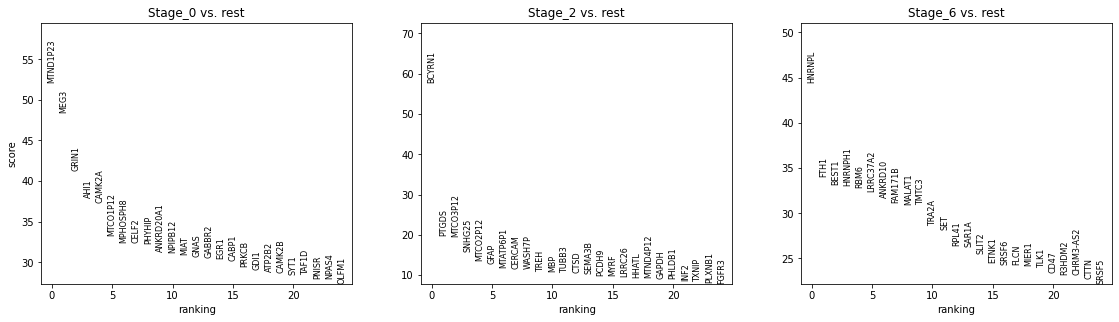

In [6]:
ex_=sfg_ad.loc[sfg_ad['predicted.celltype']=='Ex',[x for x in sfg_ad.columns if x not in rtes]]
adata=anndata.AnnData(X=np.expm1(ex_.iloc[:,:-4]))

adata.obs['Diagnosis']=ex_['Diagnosis']
adata.obs['CellType']=ex_['predicted.celltype']
adata.obsm['X_umap']=ex_[['UMAP_1','UMAP_2']].to_numpy()
adata.var["mito"] = adata.var_names.str.startswith("MT-")
adata.layers["counts"] = adata.X.copy()
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# fig,axs=plt.subplots(1,3,figsize=[45,8])

non_mito=np.invert(adata.var_names.str.startswith("MT-"))
adata=adata[:,non_mito]
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)
sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata, color='CellType')
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
gene_markers=[]
marker_list=np.array(adata.uns['rank_genes_groups']['names'].tolist()).flatten()
for i in marker_list:
    if i not in gene_markers:
        gene_markers.append(i)
extended_markers=gene_markers[:730*2]
gene_markers=gene_markers[:730]

### Compare ML models

#### RTE only

Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


RBF SVM 0.7845673505798394 22420 7561 8373 6486
Random Forest 0.741971454058876 22420 7561 8373 6486
AdaBoost 0.7236842105263158 22420 7561 8373 6486


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

MLP 0.7798840321141838 22420 7561 8373 6486


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

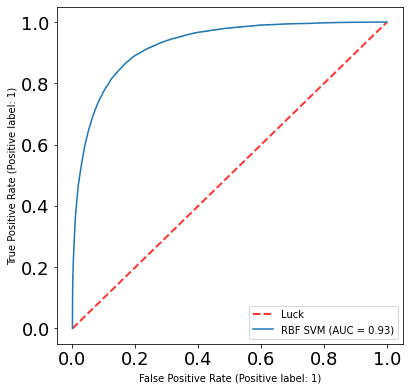

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


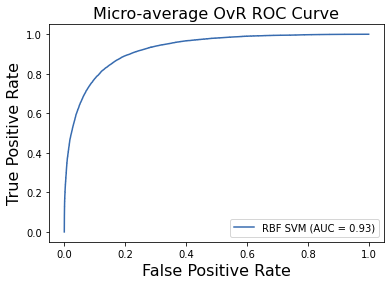

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


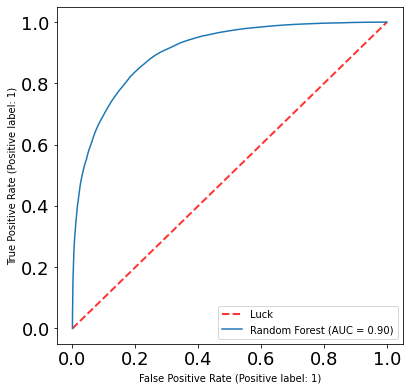

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


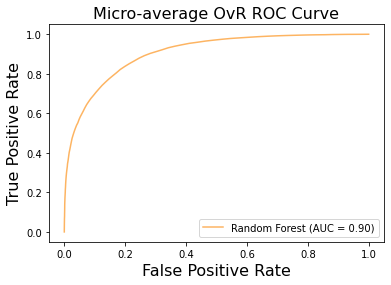

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


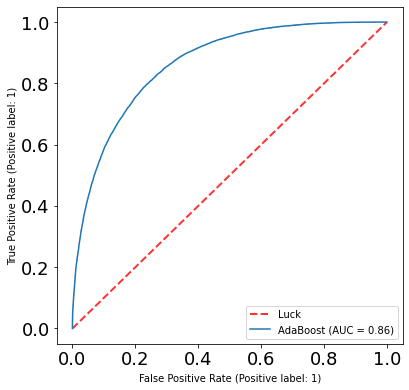

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


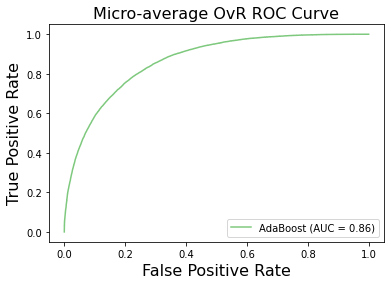

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


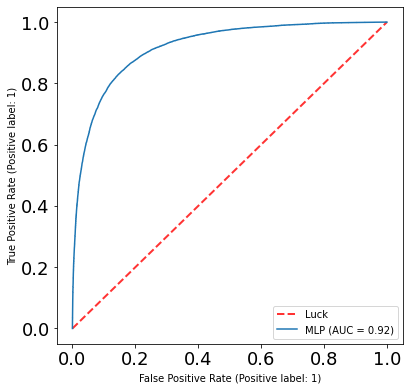

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


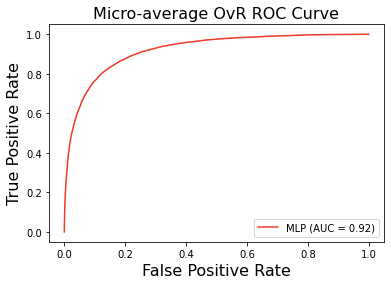

In [7]:
### Prepare data
cell='Ex'
cell_exp=sfg_ad.loc[sfg_ad['predicted.celltype']==cell,:]
cell_exp.iloc[:,:-4]=np.expm1(cell_exp.iloc[:,:-4].astype(float))
rte_exp=cell_exp[[x for x in cell_exp.columns if x in rtes]]
factors=pd.factorize(cell_exp['Diagnosis'])
labels=factors[0]

### Define models
classifiers = [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(n_estimators=100,random_state=42),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))]
names = [
    "RBF SVM",
    "Random Forest",
    "AdaBoost",
    "MLP"
]
colors=['#386cb0','#fdb462','#7fc97f','#ef3b2c','#662506','#a6cee3','#fb9a99','#984ea3','#ffff33','#6060f4','#ad27ad']

### Cross validation
scores=[cv_auc(classifiers,names,rte_exp.to_numpy(),labels,'RTE730',i,color=colors[i]) for i in range(len(classifiers))]

### Indenpendent testing
definitions=factors[1]
x_train,x_test,y_train,y_test = train_test_split(rte_exp.to_numpy(),labels,test_size=0.2,random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


if True:# not os.path.isfile(f'../data/analysis/models/{names[0]}_RTE.joblib'):
    for i in range(len(classifiers)):
        cls = classifiers[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_RTE.joblib')
else:
    classifiers=[load(f'../data/analysis/models/{names[i]}_RTE.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
t_labels=['Stage_6','Stage_2','Stage_0']
for i in range(len(classifiers)):
    cls = classifiers[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_rte_cm.csv',index=True,header=True)

importances = classifiers[1].feature_importances_
importances=pd.Series(importances, index=rte_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers[1].estimators_], axis=0),index=rte_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/rte_importances.csv',index=True,header=True)

[1] "RBF SVM"
[1] "Random Forest"


[1] "AdaBoost"
[1] "MLP"
png 
  2 


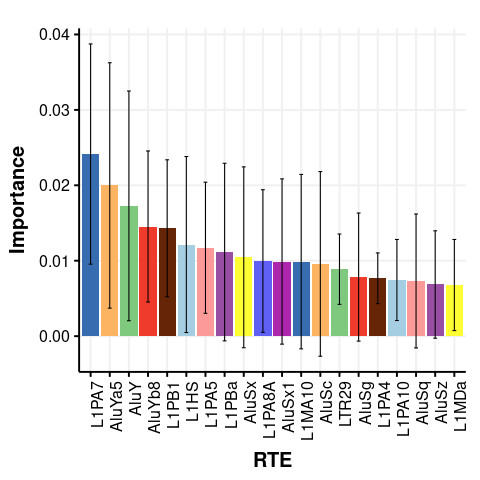

In [10]:
%%R
ps<-list()
pdf('../data/analysis/figures/rte_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     print(name)
     df<-read.csv(paste0('../data/analysis/models/',name,'_rte_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
          cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
          show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
          bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
          show_row_names = FALSE,
          heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
          rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     print(p)
}

dev.off()

df<-read.csv('../data/analysis/rte_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Importance')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/rte_importances.pdf')
print(p)
dev.off()

#### Gene 200

Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


RBF SVM 0.8282783229259589 22420 7561 8373 6486
Random Forest 0.8325156110615521 22420 7561 8373 6486
AdaBoost 0.7702943800178412 22420 7561 8373 6486


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

MLP 0.8206958073148974 22420 7561 8373 6486


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


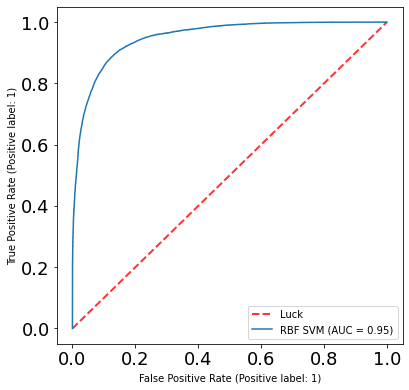

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


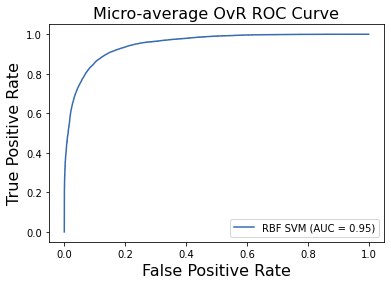

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


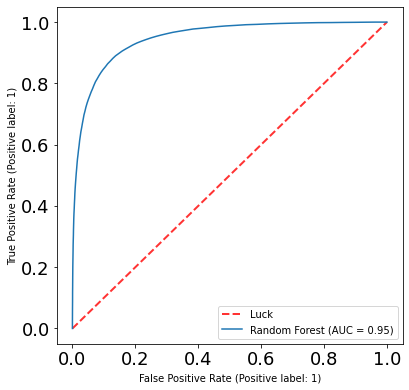

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


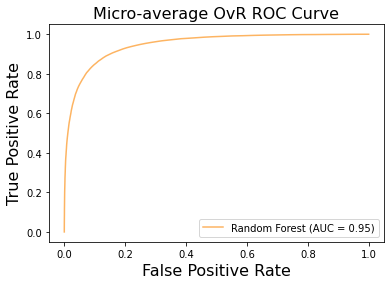

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


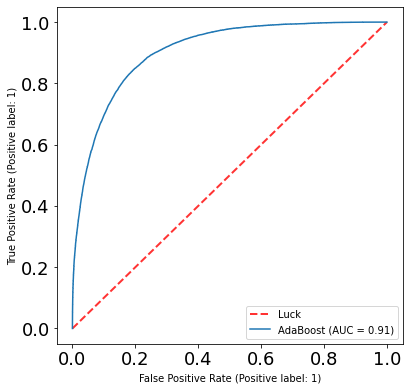

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


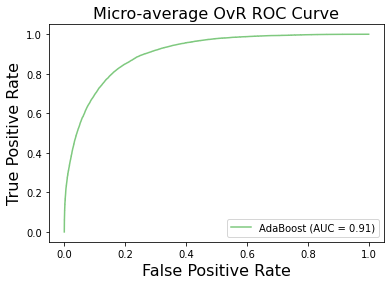

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


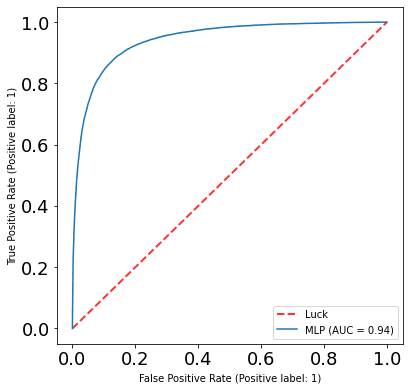

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


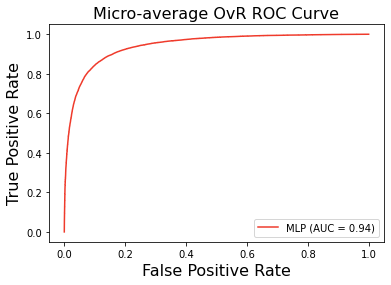

In [11]:
gene_200=cell_exp.loc[:,gene_markers[:200]]

### Define models
classifiers_gene200= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
scores_gene200=[cv_auc(classifiers_gene200,names,gene_200.to_numpy(),labels,'Gene200',i,color=colors[i]) for i in range(len(classifiers_gene200))]

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(gene_200.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

if True:#not os.path.isfile(f'../data/analysis/models/{names[0]}_gene.joblib'):
    for i in range(len(classifiers_gene200)):
        cls = classifiers_gene200[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_gene.joblib')
else:
    classifiers_gene200=[load(f'../data/analysis/models/{names[i]}_gene.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
for i in range(len(classifiers_gene200)):
    cls = classifiers_gene200[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),
          len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_gene200_cm.csv',index=True,header=True)

#### Gene 500

Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.
Thread started.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


RBF SVM 0.8389830508474576 22420 7561 8373 6486
Random Forest 0.8325156110615521 22420 7561 8373 6486
AdaBoost 0.7685102586975915 22420 7561 8373 6486


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

MLP 0.8528099910793934 22420 7561 8373 6486


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


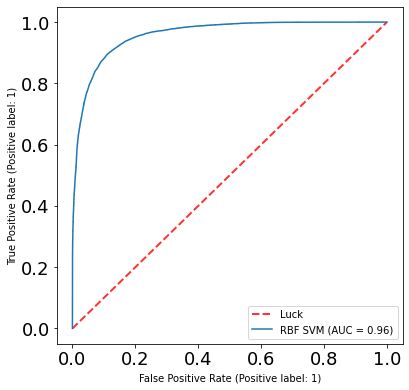

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


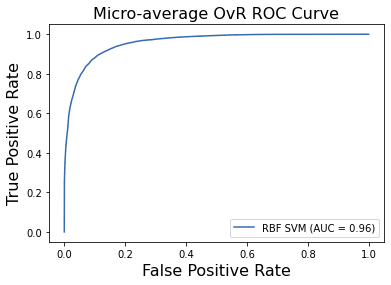

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


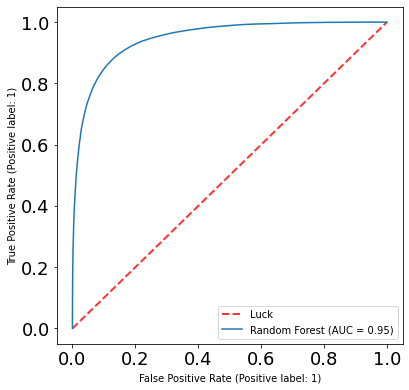

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


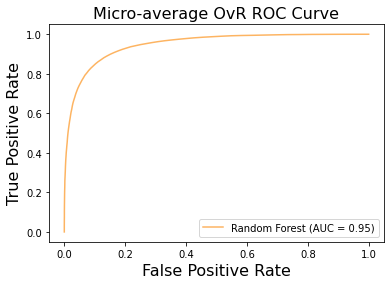

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


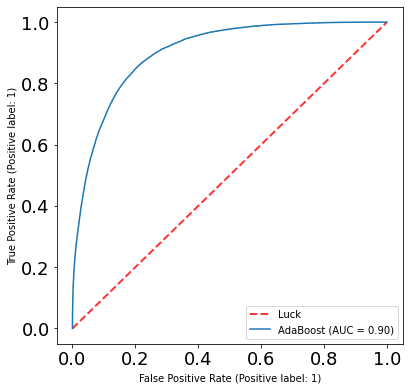

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


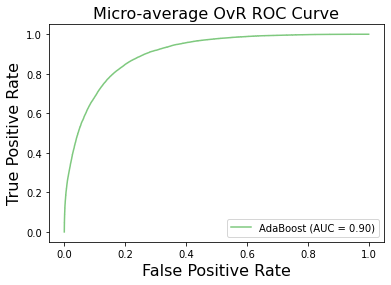

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


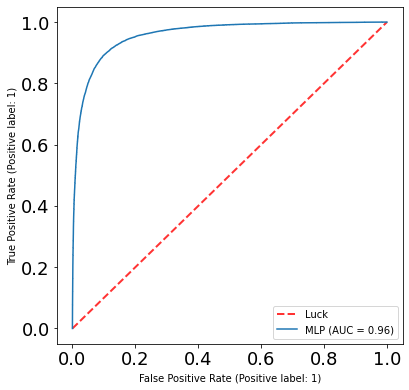

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


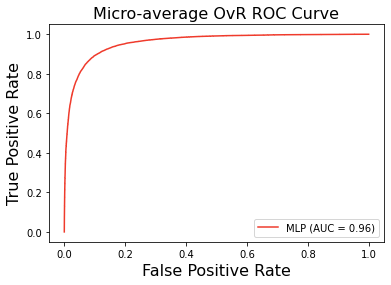

In [12]:
gene_500=cell_exp.loc[:,gene_markers[:500]]

### Define models
classifiers_gene500= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
scores_gene500=[cv_auc(classifiers_gene500,names,gene_500.to_numpy(),labels,'Gene500',i,color=colors[i]) for i in range(len(classifiers_gene500))]

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(gene_500.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

for i in range(len(classifiers_gene500)):
    cls = classifiers_gene500[i]
    cls.fit(x_train, y_train)
    # dump(cls, f'../data/analysis/models/{names[i]}_gene.joblib')


# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
for i in range(len(classifiers_gene500)):
    cls = classifiers_gene500[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),
          len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_gene500_cm.csv',index=True,header=True)

#### Gene only

In [38]:
gene_exp=cell_exp.loc[:,gene_markers]

### Define models
classifiers_gene= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
# scores_gene730=[cv_auc(classifiers_gene,names,gene_exp.to_numpy(),labels,'Gene730',i,color=colors[i]) for i in range(len(classifiers_gene))]

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(gene_exp.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

if True:#not os.path.isfile(f'../data/analysis/models/{names[0]}_gene.joblib'):
    for i in range(len(classifiers_gene)):
        cls = classifiers_gene[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_gene.joblib')
else:
    classifiers_gene=[load(f'../data/analysis/models/{names[i]}_gene.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
t_labels=['Stage_6','Stage_2','Stage_0']
for i in range(len(classifiers_gene)):
    cls = classifiers_gene[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_gene_cm.csv',index=True,header=True)

importances = classifiers_gene[1].feature_importances_
importances=pd.Series(importances, index=gene_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers_gene[1].estimators_], axis=0),
                                              index=gene_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/gene_importances.csv',index=True,header=True)

RBF SVM 0.847457627118644 22420 7561 8373 6486
Random Forest 0.8307314897413024 22420 7561 8373 6486
AdaBoost 0.7636039250669046 22420 7561 8373 6486
MLP 0.8592774308652988 22420 7561 8373 6486


In [20]:
%%R
ps<-list()
pdf('../data/analysis/figures/gene_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     df<-read.csv(paste0('../data/analysis/models/',name,'_gene_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
             cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
             show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
             bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
             show_row_names = FALSE,
        heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
        rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     draw(p)
     ps[[length(ps)+1]]<-p
#      break
}
# for(p in ps){
#     draw(p)
# }
dev.off()

df<-read.csv('../data/analysis/gene_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/gene_importances.pdf')
print(p)
dev.off()

png 
  2 


#### Combine gene and RTE

In [23]:
combined_exp=cell_exp.loc[:,[x for x in cell_exp.columns if x in rtes]+gene_markers]

### Define models
classifiers_combined= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
scores_combined=[cv_auc(classifiers_combined,names,combined_exp.to_numpy(),labels,'RTE730',i,color=colors[i]) for i in range(len(classifiers_combined))]

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(combined_exp.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

if True:#not os.path.isfile(f'../data/analysis/models/{names[0]}_combined.joblib'):

    for i in range(len(classifiers_combined)):
        cls = classifiers_combined[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_combined.joblib')
# else:
#     classifiers_combined=[load(f'../data/analysis/models/{names[i]}_combined.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
for i in range(len(classifiers_combined)):
    cls = classifiers_combined[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_combined_cm.csv',index=True,header=True)

importances = classifiers_combined[1].feature_importances_
importances=pd.Series(importances, index=combined_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers_combined[1].estimators_], axis=0),index=combined_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/combined_importances.csv',index=True,header=True)

RBF SVM 0.8623996431757359 22420 7561 8373 6486
Random Forest 0.8099910793933988 22420 7561 8373 6486
AdaBoost 0.7607047279214987 22420 7561 8373 6486
MLP 0.8704281891168599 22420 7561 8373 6486


In [24]:
%%R
ps<-list()
pdf('../data/analysis/figures/combined_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     df<-read.csv(paste0('../data/analysis/models/',name,'_combined_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
             cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
             show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
             bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
             show_row_names = FALSE,
        heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
        rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     draw(p)
     ps[[length(ps)+1]]<-p
#      break
}
# for(p in ps){
#     print(p)
# }
dev.off()

df<-read.csv('../data/analysis/combined_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/combined_importances.pdf')
print(p)
dev.off()


png 
  2 


#### Use extended gene list (top 730x2)

In [27]:
gene_exp2=cell_exp.loc[:,extended_markers]

### Define models
classifiers_gene2= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
scores_gene2=[cv_auc(classifiers_gene2,names,gene_exp2.to_numpy(),labels,'RTE730',i,color=colors[i]) for i in range(len(classifiers_gene2))]

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(gene_exp2.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

if True:#not os.path.isfile(f'../data/analysis/models/{names[0]}_combined.joblib'):
    for i in range(len(classifiers_gene2)):
        cls = classifiers_gene2[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_extended.joblib')
# else:
#     classifiers_combined=[load(f'../data/analysis/models/{names[i]}_combined.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
for i in range(len(classifiers_gene2)):
    cls = classifiers_gene2[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_extended_cm.csv',index=True,header=True)

importances = classifiers_combined[1].feature_importances_
importances=pd.Series(importances, index=combined_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers_combined[1].estimators_], axis=0),index=combined_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/extended_importances.csv',index=True,header=True)

RBF SVM 0.8521409455842998 22420 7561 8373 6486
Random Forest 0.8146743978590544 22420 7561 8373 6486
AdaBoost 0.760035682426405 22420 7561 8373 6486
MLP 0.8588314005352364 22420 7561 8373 6486


In [29]:
%%R
pdf('../data/analysis/figures/extended_cm.pdf')
# ps<-list()
for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     print(name)
     df<-read.csv(paste0('../data/analysis/models/',name,'_extended_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
             cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
             show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
             bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
             show_row_names = FALSE,
        heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
        rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     draw(p)
     ps[[length(ps)+1]]<-p
}

dev.off()

df<-read.csv('../data/analysis/extended_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/extended_importances.pdf')
print(p)
dev.off()

[1] "RBF SVM"
[1] "Random Forest"
[1] "AdaBoost"
[1] "MLP"
png 
  2 


## RFE to select features

In [ ]:
feature_num=[[50,100],[100,100],[100,200],[200,200],[200,300],[300,300],[300,400],[400,400],[400,500],[500,500]]
classifiers_rfe= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]
for n_features_to_select,n_features_to_select_from in feature_num:
    # n_features_to_select,n_features_to_select_from=50,100#int(sys.argv[1]),int(sys.argv[2])
    cell_exp=pd.read_csv('../data/analysis/combined_exp1460.txt',sep='\t')
    sfg_umap=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_umap.txt',sep='\t',index_col=0)
    sfg_umap=sfg_umap.loc[sfg_umap['predicted.celltype']=='Ex',:]
    factors=pd.factorize(sfg_umap['Diagnosis'])
    labels=factors[0]

    clmns=list(cell_exp.columns)
    valid_features=clmns[:n_features_to_select_from]
    valid_features.extend(clmns[730:730+n_features_to_select_from])
    rfe = RFE(estimator=RandomForestClassifier(n_estimators=100,random_state=42), n_features_to_select=n_features_to_select)
    model=RandomForestClassifier(n_estimators=100,random_state=42)
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    cv_auc_core(pipeline,cell_exp[valid_features].to_numpy(),labels,
                '../data/analysis/models_rfe%s_%s/cv10.pdf'%(n_features_to_select,n_features_to_select_from))

    pipeline.fit(cell_exp[valid_features].to_numpy(),labels)
    importances = pipeline.named_steps['m'].feature_importances_

    index=list(compress(valid_features,list(pipeline[0].support_)))
    importances=pd.Series(importances, index=index)
    importances=pd.concat([importances, 
                        pd.Series(np.std([tree.feature_importances_ for tree in pipeline.named_steps['m'].estimators_], axis=0),
                                    index=index)], axis=1)
    importances.columns=['Importance','STD']

    importances=importances.sort_values(by='Importance',ascending=False)
    importances_=importances.iloc[:n_features_to_select,:]
    importances_.to_csv('../data/analysis/rfe_%s_%s.csv'%(n_features_to_select,n_features_to_select_from),index=True,header=True)

    scores = cross_val_score(pipeline, cell_exp[valid_features].to_numpy(),labels, scoring='accuracy', 
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42) , n_jobs=-1, error_score='raise')
    series=pd.Series(scores)
    series.to_csv('../data/analysis/rfe_%s_%s_acc.csv'%(n_features_to_select,n_features_to_select_from),index=False,header=False)

#### Plot mean acc of different feature numbers

In [17]:
feature_num=[[50,100],[100,100],[100,200],[200,200],[200,300],[300,300],[300,400],[400,400],[400,500],[500,500]]
accs=[]
valid_fn=[]
for features in feature_num:
    if os.path.isfile(f'../data/analysis/rfe_{features[0]}_{features[1]}_acc.csv'):
        print(f'loading data: {features} \n')
        valid_fn.append(features)
        accs.append(pd.read_csv(f'../data/analysis/rfe_{features[0]}_{features[1]}_acc.csv',header=None).values.ravel())
    elif os.path.isfile(f'../data/analysis/rfe_RF_{features[0]}_{features[1]}_acc.csv'):
        print(f'loading data: {features} \n')
        valid_fn.append(features)
        accs.append(pd.read_csv(f'../data/analysis/rfe_RF_{features[0]}_{features[1]}_acc.csv',header=None).values.ravel())

# accs.append(pd.read_csv('../data/analysis/RTE730_Random Forest_acc.csv',header=None).values.ravel())
# accs.append(pd.read_csv('../data/analysis/Gene730_Random Forest_acc.csv',header=None).values.ravel())
# accs.append(pd.read_csv('../data/analysis/Gene500_Random Forest_acc.csv',header=None).values.ravel())
# accs.append(pd.read_csv('../data/analysis/Gene200_Random Forest_acc.csv',header=None).values.ravel())
accs=pd.DataFrame(accs)

accs=accs.transpose()
clmns=[f'n={x[0]} N={x[1]}' for x in valid_fn]
# clmns.extend(['RTE730','Gene730','Gene500','Gene200'])
accs.columns=clmns
accs.to_csv('../data/analysis/rfe_accs.csv',sep='\t',index=False,header=True)

loading data: [50, 100] 

loading data: [100, 100] 

loading data: [100, 200] 

loading data: [200, 200] 

loading data: [200, 300] 

loading data: [300, 300] 

loading data: [300, 400] 

loading data: [400, 400] 

loading data: [400, 500] 

loading data: [500, 500] 



R[write to console]: No id variables; using all as measure variables



png 
  2 


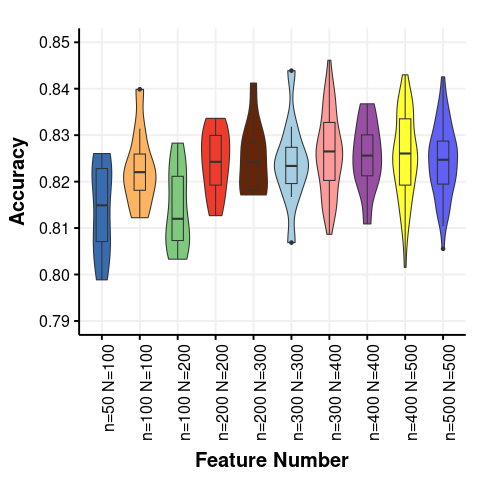

In [35]:
%%R
library(reshape2)
df<-read.csv('../data/analysis/rfe_accs.csv',sep='\t',header=T,check.names =F)
meltdf<-melt(df)
colnames(meltdf)<-c('FeatureN','Accuracy')

p<-ggplot(data=meltdf,aes(x=FeatureN,y=Accuracy,fill=FeatureN))+geom_violin()+theme_Publication()+
 scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+
 xlab('Feature Number')+ylab('Accuracy')+scale_y_continuous(limits=c(0.79,0.85),breaks=seq(0.79,0.85,by=0.01))+
 geom_boxplot(width=0.3)
print(p)
pdf('../data/analysis/figures/rfe_acc.pdf')
print(p)
dev.off()

png 
  2 


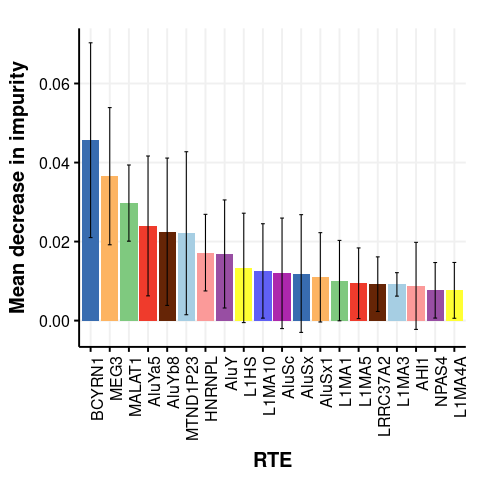

In [37]:
%%R
df<-read.csv('../data/analysis/rfe_RF_200_200.csv')
df<-df[0:20,]
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+
 theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/rfe_RF_200_200.pdf')
print(p)
dev.off()